## Load Dependencies

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import wordnet

### Initial Setup

In [3]:
import os
os.getcwd()

'd:\\ironhack_bootcamp\\main-bootcamp\\week7\\fake-news-detection-nlp\\notebooks'

In [4]:
os.chdir(r"D:\ironhack_bootcamp\main-bootcamp\week7\fake-news-detection-nlp")
os.getcwd()

'D:\\ironhack_bootcamp\\main-bootcamp\\week7\\fake-news-detection-nlp'

## Load Dataset

In [5]:
data = pd.read_csv(r"dataset\processed\clean_dataset.csv", sep=",")
df =data.copy()

df.head()

,news_headline,label
0,donald trump sends embarrass new year eve mess...,0
1,drunk brag trump staffer start russian collusi...,0
2,sheriff david clarke become internet joke thre...,0
3,trump obsess even obama name cod website image,0
4,pope francis call donald trump christmas speech,0


In [6]:
df.shape

(34143, 2)

In [7]:
df.isna().sum()

news_headline    0
label            0
dtype: int64

In [8]:
df.dropna(inplace= True)

In [9]:
pd.set_option('display.max_colwidth', 200)
df.sample(10)

,news_headline,label
24881,supporter trump break campaign promise peril,1
6843,george clooney specific reason support hillary video,0
26954,funding battle begin house bill regulator agency,1
13730,awesome dennis miller go nevertrumpers,0
33690,russian back syria congress may happen next month focus constitution ria,1
2122,trump get own hard mcdonald twitter account internet lovin screenshots,0
20556,top senate republican express optimism healthcare bill trump meeting,1
27550,senate committee take bill cftc,1
5710,hillary give huge middle finger gop bigot surprise show nyc pride parade,0
21362,trump nominates former fund manager quintenz serve cftc white house,1


### Separate Label

In [10]:
# Split the dataset

# Features & Target
X = df['news_headline']           
y = df['label']            
X.sample(10)

18383                                              multinationals grapple republican excise tax surprise
9378                                controversy school brave student wear fake news shirt field trip cnn
10778                                    report president trump replace sean spicer fox news personality
15691    boom senator lindsey graham reason believe clinton camp doj collude hillary investigation video
29527                                               nearly man ramaphosa edge close south africa top job
21914                                                     u lawmaker back syria strike demand plan trump
9436                                wow japan prime minister literally back flip bunker golf trump video
31095                                  turkish president call accusation family bank transfer abroad lie
2929                             twitter mercilessly wreck trump post celebratory inauguration day tweet
15490                                       illegal ali

### Split the Dataset

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train size:", X_train.shape)
print("X_test size:", X_test.shape)
print("y_train size:", y_train.shape)
print("y_test size:", y_test.shape)

X_train size: (27314,)
X_test size: (6829,)
y_train size: (27314,)
y_test size: (6829,)


In [12]:
y_train.value_counts()

label
0    14050
1    13264
Name: count, dtype: int64

In [13]:
from src.vectorize import get_vectorize

_ , feature_names, X_train_vec, X_test_vec = get_vectorize(X_train, X_test, method='bow', ngram_range= (1,1), min_df= 10 , max_df= 1.0, max_features=10000)

print(len(feature_names))

I am Vectorizer using Bag of Words
Vectorization completed
Train shape: (27314, 3185)
Test shape : (6829, 3185)
3185


In [14]:
X_train_vec[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]], shape=(1, 3185))

In [15]:
first_doc = X_train_vec[0].toarray()[0]

for word, count in zip(feature_names, first_doc):
    if count > 0:
        print(word, count)

give 1
list 1
magazine 1
make 1
people 1
person 1
president 1
review 1
stun 1
time 1
trump 1
world 1


In [16]:
metrics_df = pd.DataFrame()

In [17]:
from utils.bow_vectorize import *
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = [
    LogisticRegression(), 
    LinearSVC(), 
    MultinomialNB(), 
    RandomForestClassifier(n_estimators= 500, max_depth= 10), 
    XGBClassifier(n_estimators= 500, max_depth= 10)
]

ngram_vals = [(1, 1), (1, 2), (1, 3), (2, 2)]
min_df_vals = [1, 10, 20]
max_df_vals = [0.90, 0.95, 0.99]

for model in models:
    for n in ngram_vals:
        for m in min_df_vals:
            for j in max_df_vals:

                row = run_bow_experiment(
                    model=model,
                    X_train=X_train,
                    X_test=X_test,
                    y_train=y_train,
                    y_test=y_test,
                    ngram_range=n,
                    min_df=m,
                    max_df=j,
                    comments=f"ngram={n}, min_df={m}, max_df={j}"
                )
                metrics_df = pd.concat(
                    [metrics_df, pd.DataFrame([row])],
                    ignore_index=True
                )

In [18]:
metrics_df = metrics_df[metrics_df['gap_percent']>0]
metrics_df.round(4).sort_values(by='test_f1', ascending= False).head()

,model,ngram_range,min_df,max_df,features_rec,max_features,test_accuracy,train_f1,test_f1,gap_percent,comments
11,LogisticRegression,"(1, 2)",1,0.99,10000,10000,0.9326,0.9735,0.9318,4.17,"ngram=(1, 2), min_df=1, max_df=0.99"
9,LogisticRegression,"(1, 2)",1,0.90,10000,10000,0.9326,0.9735,0.9318,4.17,"ngram=(1, 2), min_df=1, max_df=0.9"
10,LogisticRegression,"(1, 2)",1,0.95,10000,10000,0.9326,0.9735,0.9318,4.17,"ngram=(1, 2), min_df=1, max_df=0.95"
18,LogisticRegression,"(1, 3)",1,0.90,10000,10000,0.9321,0.9744,0.9311,4.33,"ngram=(1, 3), min_df=1, max_df=0.9"
19,LogisticRegression,"(1, 3)",1,0.95,10000,10000,0.9321,0.9744,0.9311,4.33,"ngram=(1, 3), min_df=1, max_df=0.95"


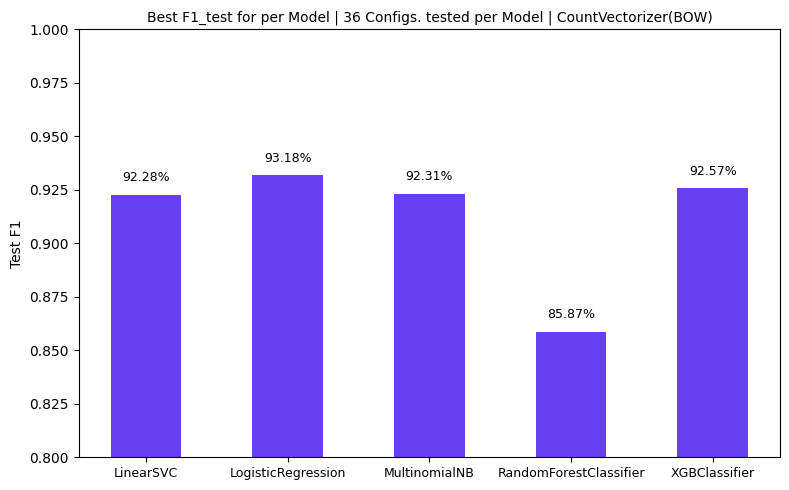

In [19]:
# Get best config per model
best_per_model =  metrics_df.sort_values("test_f1", ascending=False).groupby("model").first().reset_index()
total_configs = len(ngram_vals) * len(min_df_vals) * len(max_df_vals)
plt.figure(figsize=(8,5))

bars = plt.bar(
    best_per_model["model"],
    best_per_model["test_f1"],
    color = "#693FF3",
    width= 0.5
)
plt.title(f"Best F1_test for per Model | {total_configs} Configs. tested per Model | CountVectorizer(BOW)", fontsize = '10')
plt.xlabel("")
plt.ylabel("Test F1")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0, fontsize =9)

# Add values to labels 

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.005,
        f"{height*100:.2f}%",
        ha='center',
        va='bottom',
        fontsize= 9
    )
plt.tight_layout()

plt.show()

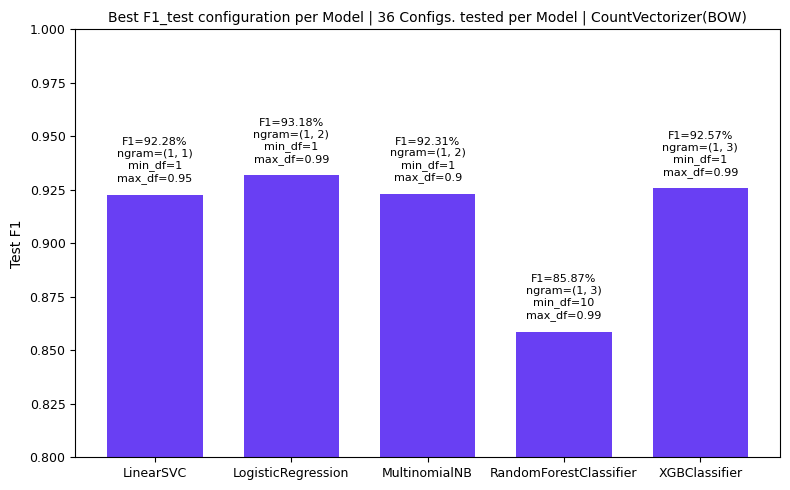

In [20]:
# Get best config per model
best_per_model = (
    metrics_df
    .sort_values("test_f1", ascending=False)
    .groupby("model")
    .first()
    .reset_index()
)

models = best_per_model["model"]
scores = best_per_model["test_f1"]

plt.figure(figsize=(8,5))

bars = plt.bar(
    models,
    scores,
    color="#693FF3",
    width = 0.7
)

plt.title(f"Best F1_test configuration per Model | {total_configs} Configs. tested per Model | CountVectorizer(BOW)", fontsize = '10') 
plt.xlabel("")
plt.ylabel("Test F1")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0, fontsize =9 )
plt.yticks(fontsize= 9)

# Add value labels + best parameters
for i, bar in enumerate(bars):
    height = bar.get_height()
    
    label_text = (
        f"F1={height*100:.2f}%\n"
        f"ngram={best_per_model['ngram_range'][i]}\n"
        f"min_df={best_per_model['min_df'][i]}\n"
        f"max_df={best_per_model['max_df'][i]}"
    )
    
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.005,
        label_text,
        ha="center",
        va="bottom",
        fontsize=8
    )
plt.tight_layout()
plt.show()

In [25]:
metrics_df.to_csv("results/bow_lr_svm_nb_rf_xgb_results.csv")

### Additional Expriment

In [22]:

from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression()

_, _, lr_X_train_vec, lr_X_test_vec = get_vectorize(
    X_train,
    X_test,
    method='bow',
    ngram_range=(1,2),
    min_df=1,
    max_df=0.99
)

# Fit model
lr_model = lr.fit(lr_X_train_vec, y_train)

# Predictions
y_pred_test = lr_model.predict(lr_X_test_vec)
y_pred_train = lr_model.predict(lr_X_train_vec)

# Classification report (test)
report = classification_report(y_test, y_pred_test)

print(report)

I am Vectorizer using Bag of Words
Vectorization completed
Train shape: (27314, 10000)
Test shape : (6829, 10000)
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3513
           1       0.92      0.95      0.93      3316

    accuracy                           0.93      6829
   macro avg       0.93      0.93      0.93      6829
weighted avg       0.93      0.93      0.93      6829



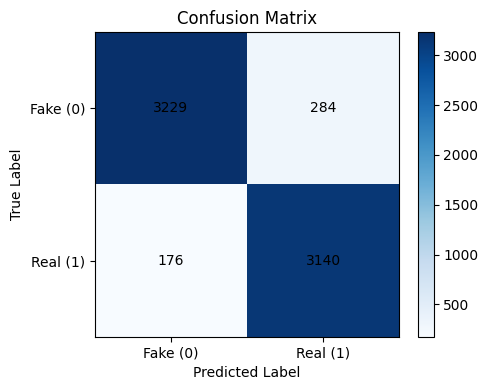

In [23]:
# Compute confusion matrix
con_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,4))

plt.imshow(con_matrix, interpolation='nearest', cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

# Custom labels
labels = ["Fake (0)", "Real (1)"]

plt.xticks([0,1], labels)
plt.yticks([0,1], labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add values inside cells
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        plt.text(
            j, i,
            con_matrix[i, j],
            ha="center",
            va="center",
            color="black"
        )

plt.tight_layout()
plt.show()